In [151]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.externals import joblib
import lightgbm as lgb
from sklearn.utils import shuffle
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [165]:
train_df=pd.read_csv(r'D:\study\Competition\porto-sequro-safe-driver-prediction\data\train.csv',na_values=-1)
test_df=pd.read_csv(r'D:\study\Competition\porto-sequro-safe-driver-prediction\data\test.csv',na_values=-1)
#sample_df=pd.read_csv(r'D:\study\Competition\porto-sequro-safe-driver-prediction\data\sample_submission.csv')

# 1 Data Analysis
## 1.1 缺失值

In [166]:
train_df.isnull().sum()[train_df.isnull().sum()>0]

ps_ind_02_cat       216
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_05_cat    266551
ps_car_07_cat     11489
ps_car_09_cat       569
ps_car_11             5
ps_car_12             1
ps_car_14         42620
dtype: int64

## 1.2 转换数据类型 

In [167]:
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]

In [168]:
use_features=[x for x in train_df.columns if x not in ['id','target']]

In [169]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [170]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,stratify=y,random_state=9)

#### 把训练集中的正负样本分开，便于后续下采样

In [171]:
X_train_p=X_train.loc[y_train==1]
X_train_n=X_train.loc[y_train==0]
y_train_p=y_train[y_train==1]
y_train_n=y_train[y_train==0]

#### 从负样本中无放回抽取与正样本数量一致的样本，做下采样平衡，该部分数据主要用于调参

In [172]:
X_train_n_sample,y_train_n_sample=shuffle(X_train_n,y_train_n,random_state=9,n_samples=X_train_p.shape[0])

In [173]:
X_train_n_sample.shape,y_train_n_sample.shape

((16271, 57), (16271,))

In [174]:
X_train_sample,y_train_sample=shuffle(X_train_p.append(X_train_n_sample),y_train_p.append(y_train_n_sample),random_state=99)

# 2 Base line

In [208]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',-gini(y, preds) / gini(y, y)

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def modelfit(alg,X,y,X_test,y_test,cat_features,cv_params,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    if useTrainCV==True:
        dtrain=lgb.Dataset(X,label=y,categorical_feature =cat_features,free_raw_data=False)
        dtrain.construct()
        cvresult=lgb.cv(cv_params,dtrain,num_boost_round=50000,nfold=cv_folds,metrics='auc',
                        early_stopping_rounds=early_stopping_rounds,verbose_eval=20,show_stdv =True,
                       seed =9)
        alg.set_params(n_estimators=len(cvresult['auc-mean']))
        print('Best Iteration:',len(cvresult['auc-mean']))
        
    alg.fit(X,y,eval_metric='auc',categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    #print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    #print('Test Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y_test,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    plt.figure()
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    plt.ylabel('Feature Importance Score')
    return feat_imp

def turnParams(model,X,y,searchParam,modelparams,cat_features,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    
    gsc.fit(X,y,eval_metric='roc_auc',categorical_feature=cat_features)
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score']).T
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [246]:
params={'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_bin': 255,
 'max_depth': 4,
 'min_child_samples': 10,
 'min_child_weight': 5,
 'min_split_gain': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'num_leaves': 3,
 'tree_learner':'feature',
 'num_threads':2,
 'objective':'binary' ,
 'random_state': 9,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample':1.0 ,
 'subsample_for_bin': 100,
 'subsample_freq': 1}

cv_params={'boosting': 'gbdt',
 'feature_fraction': 1.0,
 'feature_fraction_seed':9,
 'learning_rate': 0.1,
 'max_bin': 255,
 'max_depth': 4,
 'min_data_in_leaf': 10,
 'min_sum_hessian_in_leaf': 5,
 'min_gain_to_split': 0.0,
 'num_leaves': 3,
 'tree_learner':'feature',
 'num_threads':2,
 'objective':'binary' ,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'bagging_fraction':1.0 ,
 'bagging_freq':0,
 'bagging_seed':9,
 'zero_as_missing':False,
 'use_missing':True}

In [241]:
lgbc=lgb.LGBMClassifier(**params)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1002: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[20]	cv_agg's auc: 0.613484 + 0.00404133
[40]	cv_agg's auc: 0.615667 + 0.00442931
[60]	cv_agg's auc: 0.616362 + 0.00364391
[80]	cv_agg's auc: 0.615188 + 0.00402136
Best Iteration: 56


C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1004: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


Model report on trian:
Train Accuracy:0.6467
Train AUC:0.7034
Model report on test:
Test Accuracy:0.6063
Test AUC:0.6214
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.61      0.75    143380
          1       0.05      0.56      0.09      5423

avg / total       0.94      0.61      0.72    148803

Test confusion matrix:
Confusion matrix, without normalization
[[87178 56202]
 [ 2384  3039]]


ps_car_08_cat       0
ps_calc_16_bin      0
ps_calc_15_bin      0
ps_calc_06          0
ps_car_11           0
ps_car_10_cat       0
ps_calc_19_bin      0
ps_car_02_cat       0
ps_ind_18_bin       0
ps_ind_14           0
ps_ind_13_bin       0
ps_calc_20_bin      0
ps_ind_11_bin       0
ps_ind_10_bin       0
ps_ind_12_bin       0
ps_ind_04_cat       1
ps_calc_09          1
ps_ind_08_bin       1
ps_calc_18_bin      1
ps_calc_17_bin      2
ps_car_04_cat       2
ps_car_05_cat       2
ps_calc_05          2
ps_calc_03          2
ps_calc_02          2
ps_calc_01          2
ps_calc_12          2
ps_car_12           2
ps_calc_11          3
ps_calc_10          3
ps_calc_13          3
ps_calc_07          4
ps_calc_04          4
ps_ind_01           4
ps_calc_08          5
ps_car_14           5
ps_calc_14          6
ps_ind_09_bin       6
ps_car_06_cat       7
ps_ind_07_bin       8
ps_ind_06_bin       9
ps_ind_02_cat      10
ps_car_15          11
ps_ind_16_bin      11
ps_reg_02          11
ps_car_07_

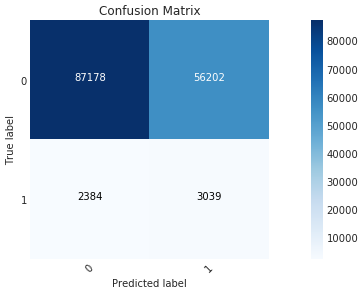

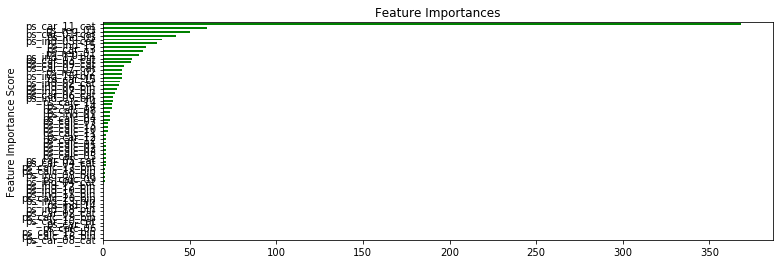

In [242]:
modelfit(lgbc,X_train_sample,y_train_sample,X_test,y_test,cat_features,cv_params,useTrainCV=True,
         cv_folds=5,early_stopping_rounds=30)

In [247]:
params['n_estimators']=105

## 2.1 Tune Params

In [248]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'learning_rate': 0.1,
 'max_bin': 255,
 'max_depth': 4,
 'min_child_samples': 10,
 'min_child_weight': 5,
 'min_split_gain': 0.0,
 'n_estimators': 105,
 'n_jobs': -1,
 'num_leaves': 3,
 'num_threads': 2,
 'objective': 'binary',
 'random_state': 9,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 100,
 'subsample_freq': 1,
 'tree_learner': 'feature'}

### （1）num_leaves

In [249]:
searchParam={'num_leaves':[2,3,4,5,6]}
turnParams(lgbc,X_train_sample,y_train_sample,searchParam,params,cat_features,scoring='roc_auc',cv=5)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1004: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1004: UserWarning: categorical_feature in Dataset is overrided. New categorical_feature is ['ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat', 'ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat']
  warnings.warn('categorical_feature in Dataset is overrided. New categorical_feat

Best params:
num_leaves : 4
Best score: 0.623088207493
   mean_test_score  mean_train_score  std_test_score  std_train_score
0         0.622867          0.634968        0.005385         0.001113
1         0.622806          0.661184        0.005575         0.001122
2         0.623088          0.674567        0.004302         0.001202
3         0.621796          0.687163        0.005546         0.001110
4         0.621380          0.697443        0.004527         0.001551


In [250]:
params['num_leaves']=2

In [254]:
lgbc_opt=lgb.LGBMClassifier(**params)

In [255]:
lgbc_opt.fit(X_train_sample,y_train_sample)

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_bin=255, max_depth=4, min_child_samples=10, min_child_weight=5,
        min_split_gain=0.0, n_estimators=105, n_jobs=-1, num_leaves=2,
        num_threads=2, objective='binary', random_state=9, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0, subsample_for_bin=100,
        subsample_freq=1, tree_learner='feature')

In [257]:
pred_prob=lgbc_opt.predict_proba(X_predict)[:,1]

In [258]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [259]:
predict_result.head()

,id,target
0,0,0.410071
1,1,0.433540
2,2,0.479625
3,3,0.373717
4,4,0.509186


In [260]:
predict_result.to_csv(r'D:\study\Competition\porto-sequro-safe-driver-prediction\pred_results\20171017_06lgbm_predict_result.csv',index=False)